<a href="https://colab.research.google.com/github/itsjustdinesh/A-Statistical-Analysis-of-Cycling-Performance-Across-Rider-and-Stage-Classifications-/blob/main/Cycling_Performance_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Loading the dataset and performing the requested statistical analysis.
# This code will:
# 1. Load /mnt/data/cycling.txt
# 2. Show first rows and summary statistics
# 3. Compute descriptive stats by rider_class
# 4. Run Shapiro-Wilk on residuals after one-way ANOVA model
# 5. Run Levene's test for homogeneity of variances
# 6. Run one-way ANOVA, Kruskal-Wallis, Tukey HSD, Dunn post-hoc
# 7. Create two plots: boxplot by rider class, and interaction plot (mean points by rider x stage)
# Note: matplotlib is used (no seaborn) for plots as required.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import os

# Load the data
path = '/content/cycling.txt'
df = pd.read_csv(path, sep='\t')   # or use sep='\s+' if needed
df.head()




,"all_riders ""rider_class"" ""stage"" ""points"" ""stage_class"""
0,"Tadej Pogačar ""All Rounder"" ""X1"" 15 ""flat"""
1,"Tadej Pogačar ""All Rounder"" ""X2"" 219 ""hills"""
2,"Tadej Pogačar ""All Rounder"" ""X3"" 34 ""flat"""
3,"Tadej Pogačar ""All Rounder"" ""X4"" 264 ""hills"""
4,"Tadej Pogačar ""All Rounder"" ""X6"" 114 ""hills"""


In [14]:
# Replace path if different
path = '/content/cycling.txt'

import re
import pandas as pd

rows = []
with open(path, 'r', encoding='utf-8') as f:
    lines = [ln.rstrip('\n') for ln in f if ln.strip()]

# Try to extract header tokens (if header got read as one string)
first = lines[0]
# If header is a single string with spaces, split it:
if '"' not in first and ' ' in first and '\t' not in first:
    # likely 'all_riders rider_class stage points stage_class'
    hdr = first.split()
else:
    # try to extract quoted headers
    hdr = re.findall(r'"([^"]+)"', first)
    if not hdr:
        hdr = first.split()

# Parse subsequent lines robustly: extract quoted fields and the numeric points
for line in lines[1:]:
    # Find all quoted tokens
    quoted = re.findall(r'"([^"]+)"', line)
    nums = re.findall(r'\b-?\d+\b', line)
    if len(quoted) >= 4 and nums:
        # common good case: quoted rider, rider_class, stage, stage_class + numeric points
        # But order sometimes has points as the 4th numeric token — adjust:
        # We'll map tokens to the header length if possible
        if len(quoted) >= 4:
            all_riders = quoted[0]
            rider_class = quoted[1]
            stage = quoted[2]
            # if header expects stage_class as last, attempt to get it from quoted[3]
            stage_class = quoted[3]
            # points: take first numeric token
            points = int(nums[0])
            rows.append((all_riders, rider_class, stage, points, stage_class))
            continue
    # fallback: split by whitespace and try to pick parts
    parts = line.split()
    # crude fallback — gather quoted-like tokens joined, numbers separately
    quoted_parts = re.findall(r'\"(.*?)\"', line)
    if len(quoted_parts) >= 4 and nums:
        rows.append((quoted_parts[0], quoted_parts[1], quoted_parts[2], int(nums[0]), quoted_parts[3]))
    else:
        # Last resort: attempt to split by spaces assuming columns = 5
        tokens = line.split()
        if len(tokens) >= 5:
            # assume last token is stage_class (maybe quoted), fourth is points
            points_token = tokens[-2]
            try:
                points = int(re.sub(r'[^0-9\-]', '', points_token))
                all_riders = ' '.join(tokens[:-4+1])  # best-effort
                rider_class = tokens[-4]
                stage = tokens[-3]
                stage_class = tokens[-1].strip('"')
                rows.append((all_riders, rider_class, stage, points, stage_class))
            except:
                # skip problematic line or append raw
                pass

# Build dataframe
df_clean = pd.DataFrame(rows, columns=['all_riders','rider_class','stage','points','stage_class'])

# final cleaning: strip quotes/spaces and convert points
for c in ['all_riders','rider_class','stage','stage_class']:
    df_clean[c] = df_clean[c].astype(str).str.replace('"','').str.strip()
df_clean['points'] = pd.to_numeric(df_clean['points'], errors='coerce')

# show results
print('Columns:', df_clean.columns.tolist())
print('Shape:', df_clean.shape)
display(df_clean.head(8))


Columns: ['all_riders', 'rider_class', 'stage', 'points', 'stage_class']
Shape: (3496, 5)


,all_riders,rider_class,stage,points,stage_class
0,Tadej Pogačar,All Rounder,X1,15,flat
1,Tadej Pogačar,All Rounder,X2,219,hills
2,Tadej Pogačar,All Rounder,X3,34,flat
3,Tadej Pogačar,All Rounder,X4,264,hills
4,Tadej Pogačar,All Rounder,X6,114,hills
5,Tadej Pogačar,All Rounder,X7,274,hills
6,Tadej Pogačar,All Rounder,X8,50,flat
7,Tadej Pogačar,All Rounder,X9,50,flat


In [16]:
!pip install -q scikit-posthocs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

In [17]:
df = df_clean.copy()

In [18]:
df['rider_class'] = df['rider_class'].astype('category')
df['stage_class'] = df['stage_class'].astype('category')

In [19]:
desc = df.groupby('rider_class')['points'].agg(['count','mean','median','std','min','max']).reset_index()
print("Descriptive stats by rider class:\n", desc.to_string(index=False))

Descriptive stats by rider class:
 rider_class  count      mean  median       std  min  max
All Rounder    323 37.687307    12.0 63.961640    0  304
    Climber    437 20.169336     6.0 43.447254    0  269
   Sprinter    551 15.036298     0.0 41.832247    0  272
  Unclassed   2185  6.419680     0.0 23.282527    0  260


/tmp/ipython-input-2283175681.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby('rider_class')['points'].agg(['count','mean','median','std','min','max']).reset_index()


In [20]:
# One-way ANOVA
model = ols('points ~ C(rider_class)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA table:\n", anova_table)


ANOVA table:
                       sum_sq      df          F        PR(>F)
C(rider_class)  3.148937e+05     3.0  85.505214  2.198409e-53
Residual        4.286712e+06  3492.0        NaN           NaN


In [21]:
# Residual diagnostics (Shapiro on sample of 500 to avoid Shapiro warning on large n)
resid = model.resid
sh_stat, sh_p = stats.shapiro(resid.sample(500, random_state=0))
print(f"\nShapiro-Wilk (residuals sample500): W={sh_stat:.4f}, p={sh_p:.4e}")


Shapiro-Wilk (residuals sample500): W=0.5118, p=7.1742e-35


In [22]:
# Levene's test
groups = [g['points'].values for _, g in df.groupby('rider_class')]
lev_stat, lev_p = stats.levene(*groups)
print(f"Levene's test: W={lev_stat:.4f}, p={lev_p:.4e}")


Levene's test: W=83.0757, p=6.4882e-52


/tmp/ipython-input-3092257852.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g['points'].values for _, g in df.groupby('rider_class')]


In [23]:
# Kruskal-Wallis
kw_stat, kw_p = stats.kruskal(*groups)
print(f"Kruskal-Wallis: H={kw_stat:.4f}, p={kw_p:.4e}")

Kruskal-Wallis: H=330.2007, p=2.8872e-71


In [24]:
# Tukey HSD (post-hoc for ANOVA)
tukey = pairwise_tukeyhsd(df['points'], df['rider_class'])
print("\nTukey HSD results:\n")
print(tukey.summary())


Tukey HSD results:

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1     group2  meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
All Rounder   Climber  -17.518    0.0 -24.1259   -10.91   True
All Rounder  Sprinter  -22.651    0.0 -28.9618 -16.3402   True
All Rounder Unclassed -31.2676    0.0  -36.636 -25.8993   True
    Climber  Sprinter   -5.133 0.1012 -10.9016   0.6355  False
    Climber Unclassed -13.7497    0.0 -18.4687  -9.0306   True
   Sprinter Unclassed  -8.6166    0.0 -12.9096  -4.3236   True
--------------------------------------------------------------


In [25]:
# Dunn post-hoc (non-parametric) using scikit-posthocs
dunn = sp.posthoc_dunn(df, val_col='points', group_col='rider_class', p_adjust='bonferroni')
print("\nDunn post-hoc (Bonferroni-adjusted p-values):\n", dunn)


Dunn post-hoc (Bonferroni-adjusted p-values):
               All Rounder       Climber      Sprinter     Unclassed
All Rounder  1.000000e+00  6.560854e-02  1.774560e-24  9.829659e-47
Climber      6.560854e-02  1.000000e+00  1.838582e-16  2.430592e-37
Sprinter     1.774560e-24  1.838582e-16  1.000000e+00  2.683631e-02
Unclassed    9.829659e-47  2.430592e-37  2.683631e-02  1.000000e+00


In [26]:
from itertools import combinations
pairs = list(combinations(df['rider_class'].cat.categories, 2))
pvals = []
for a,b in pairs:
    da = df.loc[df['rider_class']==a, 'points']
    db = df.loc[df['rider_class']==b, 'points']
    stat, p = stats.mannwhitneyu(da, db, alternative='two-sided')
    pvals.append((f"{a} vs {b}", p))
pairwise_df = pd.DataFrame(pvals, columns=['comparison','p_raw'])
pairwise_df['p_bonf'] = np.minimum(pairwise_df['p_raw'] * len(pairs), 1.0)
print("\nPairwise Mann-Whitney (Bonferroni adjusted):\n", pairwise_df.to_string(index=False))


Pairwise Mann-Whitney (Bonferroni adjusted):
               comparison        p_raw       p_bonf
  All Rounder vs Climber 4.196988e-04 2.518193e-03
 All Rounder vs Sprinter 7.367523e-21 4.420514e-20
All Rounder vs Unclassed 7.750452e-49 4.650271e-48
     Climber vs Sprinter 4.383646e-15 2.630187e-14
    Climber vs Unclassed 1.126900e-41 6.761402e-41
   Sprinter vs Unclassed 4.496240e-03 2.697744e-02


/tmp/ipython-input-383670655.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_plot, labels=order)


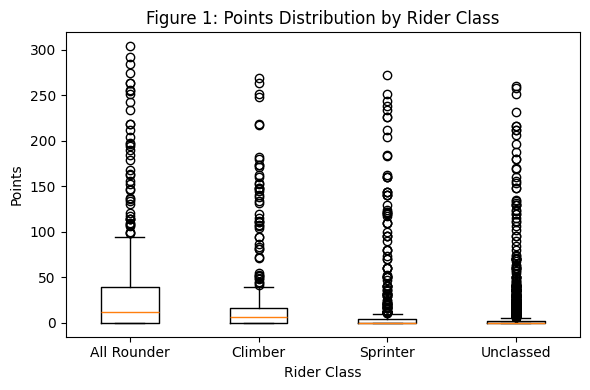

In [27]:
# Figure 1: Boxplot by rider class
plt.figure(figsize=(6,4))
order = df['rider_class'].cat.categories.tolist()
data_plot = [df.loc[df['rider_class']==g, 'points'] for g in order]
plt.boxplot(data_plot, labels=order)
plt.xlabel('Rider Class')
plt.ylabel('Points')
plt.title('Figure 1: Points Distribution by Rider Class')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1269287108.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_table = df.groupby(['rider_class','stage_class'])['points'].mean().unstack()


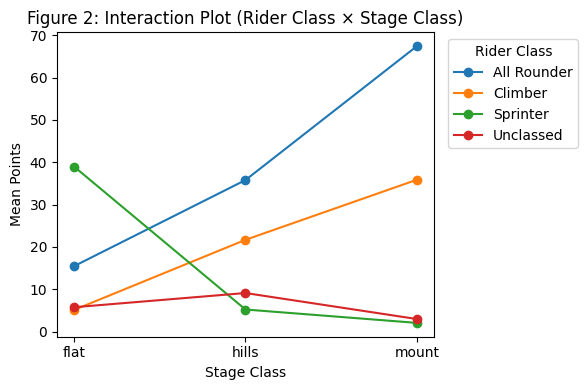

In [28]:
# Figure 2: Interaction plot (mean points by rider_class x stage_class)
mean_table = df.groupby(['rider_class','stage_class'])['points'].mean().unstack()
plt.figure(figsize=(6,4))
for cls in mean_table.index:
    plt.plot(mean_table.columns, mean_table.loc[cls], marker='o', label=cls)
plt.xlabel('Stage Class')
plt.ylabel('Mean Points')
plt.title('Figure 2: Interaction Plot (Rider Class × Stage Class)')
plt.legend(title='Rider Class', bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()